# Discrete Calculus on 2D Grids

Demonstrates graph-based discrete differential operators on structured 2D grids
using `esapp.utils.Grid2D`. The notebook builds a grid and its oriented
incidence matrix, then derives gradient, divergence, curl, and Laplacian
operators from this single matrix. It also covers the weighted Laplacian
$L = A^\top \text{diag}(w)\, A$, the Hodge star rotation, Dirichlet
boundary conditions with the Poisson equation, and Laplacian eigenmodes.

In [13]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve, eigsh as sparse_eigsh
from esapp.utils import Grid2D, sorteig, format_plot, plot_vecfield

In [14]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_grid_regions, plot_scalar_field, plot_field_panels,
    plot_gradient_vecfield, plot_hodge_rotation,
    plot_eigenmodes, plot_graph_operators, plot_spy_matrices,
    plot_incidence_directed,
)

## 1. Building a 2D Grid

`Grid2D` represents a structured rectangular grid as a graph. Internally it constructs
an **oriented incidence matrix** that encodes all edge connectivity. All discrete operators
(gradient, divergence, curl, Laplacian) are derived from this single matrix.

Points are indexed in column-major (Fortran) order: point $(x, y)$ maps to flat index $y \cdot n_x + x$.

In [15]:
nx, ny = 30, 30
grid = Grid2D((nx, ny))

print(f"Grid shape:      {grid.shape}")
print(f"Total nodes:     {grid.size}")
print(f"Total edges:     {grid.n_edges}  (horizontal: {grid.n_edges_x}, vertical: {grid.n_edges_y})")
print(f"Boundary nodes:  {grid.boundary.sum()}")
print(f"Interior nodes:  {grid.interior.sum()}")

Grid shape:      (30, 30)
Total nodes:     900
Total edges:     1740  (horizontal: 870, vertical: 870)
Boundary nodes:  116
Interior nodes:  784


### Boundary and interior regions

`Grid2D` provides boolean masks for selecting boundary and interior nodes, useful for
applying boundary conditions. These were previously in a separate `GridSelector` class.

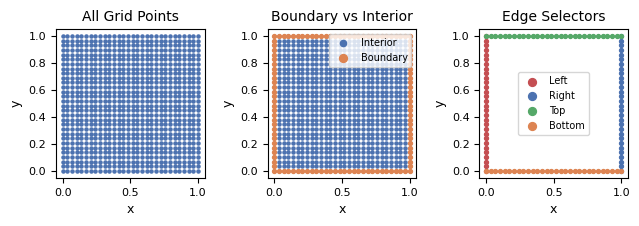

In [16]:
# Build coordinate arrays
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

plot_grid_regions(X, Y, grid)

## 2. The Incidence Matrix

The core data structure of `Grid2D` is the **oriented incidence matrix** $A$ of shape
$(m, n)$ where $m$ is the number of edges and $n$ is the number of nodes. Each row
has exactly two nonzeros: $-1$ at the **source** node and $+1$ at the **target** node.

Horizontal edges (left → right) are listed first, then vertical edges (bottom → top).

### Directed edge structure

The plot below shows a small grid with every oriented edge drawn as an arrow from
its source ($-1$) to its target ($+1$), alongside the dense incidence matrix with
annotated entries. This makes the one-to-one correspondence between rows of $A$
and directed edges visually explicit.

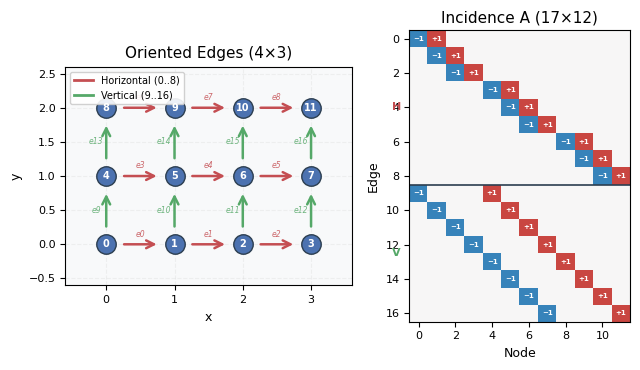

In [17]:
# Visualize directed edges on a small grid
small = Grid2D((4, 3))
plot_incidence_directed(small)

## 3. Gradient of a Scalar Field

The gradient operators $D_x$ and $D_y$ are extracted directly from the incidence matrix:
$D_x$ consists of the horizontal-edge rows and $D_y$ of the vertical-edge rows.

Applying $D_x$ to a scalar field $u$ gives the forward difference along each horizontal
edge. The result lives on edges, not nodes.

In [18]:
# Compute gradient operators and a test scalar field
Dx, Dy = grid.gradient()

# Smooth test field
f = np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)
f_flat = f.ravel(order="C")

# Gradient on edges
grad_x_edges = (Dx @ f_flat).reshape(ny, nx - 1)
grad_y_edges = (Dy @ f_flat).reshape(ny - 1, nx)

# Edge-midpoint coordinates for visualization
Xmid_h = (X[:, :-1] + X[:, 1:]) / 2
Ymid_h = (Y[:, :-1] + Y[:, 1:]) / 2

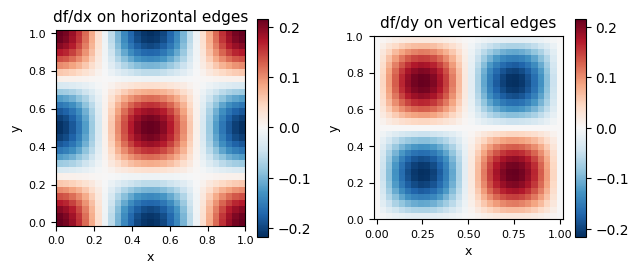

In [19]:
# Vertical edge midpoints
Xmid_v = (X[:-1, :] + X[1:, :]) / 2
Ymid_v = (Y[:-1, :] + Y[1:, :]) / 2

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.8))
im0 = axes[0].pcolormesh(Xmid_h, Ymid_h, grad_x_edges, cmap='RdBu_r', shading='auto')
fig.colorbar(im0, ax=axes[0])
axes[0].set_aspect('equal')
format_plot(axes[0], title='df/dx on horizontal edges', xlabel='x', ylabel='y',
            grid=False, plotarea='white', titlesize=11, labelsize=9, ticksize=8)

im1 = axes[1].pcolormesh(Xmid_v, Ymid_v, grad_y_edges, cmap='RdBu_r', shading='auto')
fig.colorbar(im1, ax=axes[1])
axes[1].set_aspect('equal')
format_plot(axes[1], title='df/dy on vertical edges', xlabel='x', ylabel='y',
            grid=False, plotarea='white', titlesize=11, labelsize=9, ticksize=8)
plt.tight_layout()
plt.show()

### Verifying the gradient on a linear field

For a linear field $f(x,y) = x$, the x-gradient on every horizontal edge should be
exactly 1 (the grid spacing), and the y-gradient should be zero.

In [20]:
# f(x,y) = x coordinate
f_x = np.zeros(grid.size)
for xi, yi, idx in grid.iter_points():
    f_x[idx] = x[xi]

gx = Dx @ f_x
gy = Dy @ f_x

dx = x[1] - x[0]
print(f"Grid spacing dx = {dx:.4f}")
print(f"All horizontal gradients = dx? {np.allclose(gx, dx)}")
print(f"All vertical gradients = 0?   {np.allclose(gy, 0)}")

Grid spacing dx = 0.0345
All horizontal gradients = dx? True
All vertical gradients = 0?   True


## 4. Laplacian: $L = A^\top\, \text{diag}(w)\, A$

The discrete Laplacian is constructed from the incidence matrix:

$$L = A^\top W A$$

where $W = \text{diag}(w)$ is a diagonal matrix of per-edge weights. With unit weights
($w = \mathbf{1}$), this gives the standard combinatorial Laplacian whose diagonal entries
equal the node degrees.

## 5. Divergence and Curl

The **divergence** $\text{div} = -A^\top$ maps edge fields to node fields.
The **curl** maps edge fields to face (cell) fields, summing edge values around
each rectangular cell with orientation signs.

These satisfy the discrete exactness property: $\text{curl}(\text{grad}(u)) = 0$
for any scalar field $u$.

In [21]:
D = grid.divergence()
C = grid.curl()

# Verify discrete exactness: curl(grad(u)) = 0
L = grid.laplacian()
A = grid._A
grad_f = A @ f_flat           # edge field
curl_grad = C @ grad_f        # should be zero on every face

# Divergence of the gradient gives the (negative) Laplacian
div_grad = D @ grad_f
neg_lap = -L @ f_flat

## 6. Hodge Star (90-degree Rotation)

The Hodge star operator rotates a 2D node-based vector field $[u; v]$ by 90 degrees,
returning $[-v; u]$. Applying it twice gives $-\text{Id}$.

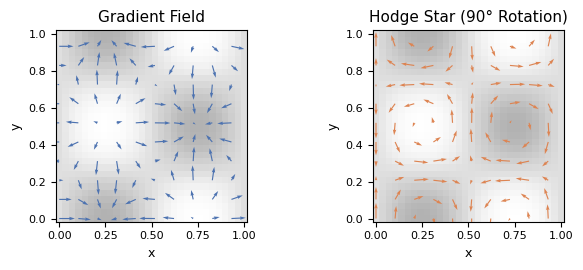

In [22]:
H = grid.hodge_star()

# Interpolate edge gradient to nodes for visualization
# Average adjacent edge values to get node-based approximation
grad_x_nodes = np.zeros((ny, nx))
grad_x_nodes[:, :-1] += grad_x_edges
grad_x_nodes[:, 1:] += grad_x_edges
grad_x_nodes[:, 1:-1] /= 2

grad_y_nodes = np.zeros((ny, nx))
grad_y_nodes[:-1, :] += grad_y_edges
grad_y_nodes[1:, :] += grad_y_edges
grad_y_nodes[1:-1, :] /= 2

# Apply Hodge star to the node-based vector field
grad_flat = np.concatenate([grad_x_nodes.ravel(order='C'),
                            grad_y_nodes.ravel(order='C')])
rotated = H @ grad_flat
rot_x = rotated[:grid.size].reshape(ny, nx)
rot_y = rotated[grid.size:].reshape(ny, nx)

plot_hodge_rotation(X, Y, f, grad_x_nodes, grad_y_nodes, rot_x, rot_y)

## 7. Boundary Conditions and the Poisson Equation

Use the boundary masks built into `Grid2D` to apply Dirichlet boundary conditions
and solve the Poisson equation $L\, u = f$ on the grid interior.

Boundary values (should be 0): max = 0.0e+00
Interior max: -19.6140


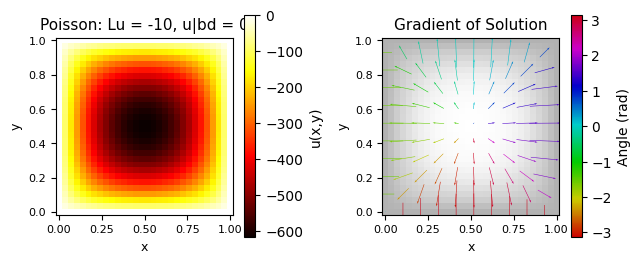

In [31]:
L = grid.laplacian()
rhs = -10 * np.ones(grid.size)

# Apply Dirichlet BC: u = 0 on boundary
L_bc = L.tolil()
for i in np.where(grid.boundary)[0]:
    L_bc[i, :] = 0
    L_bc[i, i] = 1.0
    rhs[i] = 0.0

u = spsolve(L_bc.tocsr(), rhs).reshape(ny, nx)

print(f"Boundary values (should be 0): max = {np.abs(u.ravel()[grid.boundary]).max():.1e}")
print(f"Interior max: {u.ravel()[grid.interior].max():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.8))
plot_scalar_field(X, Y, u,
                  title='Poisson: Lu = -10, u|bd = 0',
                  clabel='u(x,y)', cmap='hot', ax=axes[0], fig=fig)
plot_gradient_vecfield(X, Y, u,
                       np.gradient(u, axis=1)/3, np.gradient(u, axis=0)/3,
                       step=3, ax=axes[1], fig=fig)
axes[1].set_title('Gradient of Solution', fontsize=11)
plt.tight_layout()
plt.show()

## 8. Laplacian Eigenmodes

The eigenvectors of the discrete Laplacian are the vibration modes of the grid.
The smallest eigenvalue is always 0 (constant mode); subsequent modes capture
increasingly oscillatory patterns.

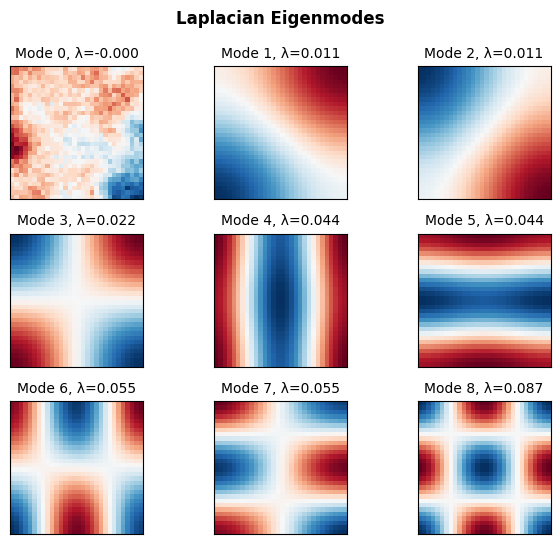

In [32]:
L = grid.laplacian()
vals, vecs = sparse_eigsh(L.astype(float), k=9, which='SM')
vals, vecs = sorteig(vals, vecs)

plot_eigenmodes(X, Y, vals, vecs, ny, nx)